# FINAL PROJECT: MNIST handwritten digit images to train a MLP  
### Group 5: Shambhavi Danayak, Kimaya D Sawant, Pradnya R Ghadge, 

#  1. Import Libraries

We first import all necessary libraries including PyTorch, torchvision for datasets and transforms, and matplotlib/numpy for visualization.

In [57]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## TASK 2: 
a helper function that can read all image files (following filename convention defined in Task1) into a Numpy array, and assign the corresponding labels in another Numpy array.  
- load ".png" handwritten data
- extract label
- verify shape
- return images and labels

In [14]:
import os
from PIL import Image

In [15]:
def ProjectDataLoader(folder_path="../HandwrittenData/digits"):
    image_list = [] #stores image pixels
    label_list = [] #corresponding digit labels

    for filename in os.listdir(folder_path):
        if filename.endswith(".png") and filename[0].isdigit():
            try:
                label = int(filename.split("-")[0])

                img_path = os.path.join(folder_path, filename)
                image = Image.open(img_path).convert("L")  # "L" = 8-bit pixels, black and white
                # Resize 
                image_array = np.array(image)

                if image_array.shape != (28, 28):
                    raise ValueError(f"Image {filename} is not 28x28 pixels")

                image_list.append(image_array)
                label_list.append(label)

            except Exception as e:
                print(f"Skipping {filename}: {e}")

    images = np.array(image_list, dtype=np.uint8)
    labels = np.array(label_list, dtype=np.int64)

    print(f"Loaded {len(images)} images and labels.")
    return images, labels


In [16]:
images, labels = ProjectDataLoader()
print("Shape of image set:", images.shape)
print("Sample label:", labels[0])

Loaded 330 images and labels.
Shape of image set: (330, 28, 28)
Sample label: 9


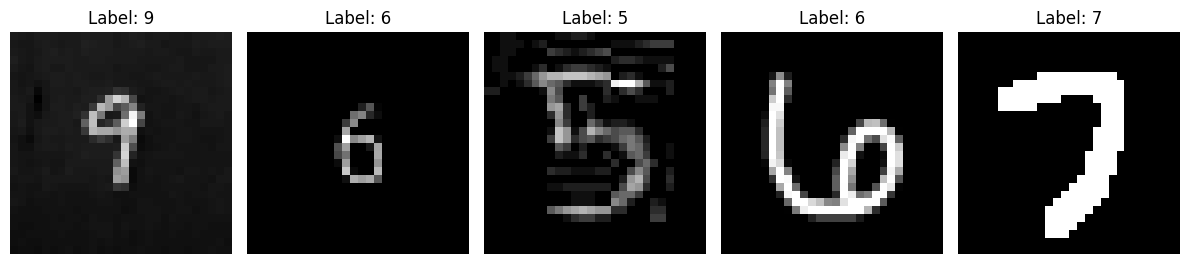

In [17]:
num_images = 5

fig, axes = plt.subplots(1, num_images, figsize=(12, 3))  

for i in range(num_images):
    axes[i].imshow(images[i], cmap='gray')
    axes[i].set_title(f"Label: {labels[i]}")
    axes[i].axis('off')  

plt.tight_layout()
plt.show()

## Task 3: Preprocess image data using Pytorch

In [18]:
def preprocess_images(images_np):
    preprocess = transforms.Compose([
        transforms.ToTensor(),                         
        transforms.Normalize((0.5,), (0.5,))           
    ])

    processed_images = []
    for i in range(images_np.shape[0]):
        img_tensor = preprocess(images_np[i])          
        processed_images.append(img_tensor)

    # Stack into a single tensor: shape → (N, 1, 28, 28)
    return torch.stack(processed_images)

In [19]:
images_tensor = preprocess_images(images)     
labels_tensor = torch.from_numpy(labels) 

In [20]:
print("Processed image tensor shape:", images_tensor.shape)
print("Pixel range:", images_tensor.min().item(), "to", images_tensor.max().item())

Processed image tensor shape: torch.Size([330, 1, 28, 28])
Pixel range: -1.0 to 1.0


In [21]:
os.makedirs("SavedData", exist_ok=True)
torch.save(images_tensor, "SavedData/images_tensor.pt")
torch.save(labels_tensor, "SavedData/labels_tensor.pt")

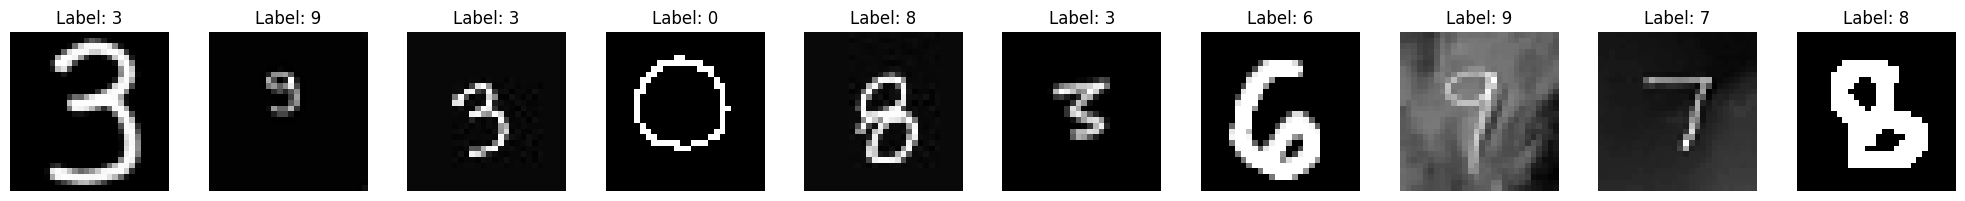

In [22]:
images_tensor = torch.load("SavedData/images_tensor.pt")
labels_tensor = torch.load("SavedData/labels_tensor.pt")
def show_random_images(images_tensor, labels_tensor, n=10):
    indices = random.sample(range(len(images_tensor)), n)
    plt.figure(figsize=(n * 2, 2))
    for i, idx in enumerate(indices):
        image = images_tensor[idx].squeeze().numpy()
        label = labels_tensor[idx].item()

        plt.subplot(1, n, i + 1)
        plt.imshow(image, cmap="gray")
        plt.title(f"Label: {label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Usage:
show_random_images(images_tensor, labels_tensor, n=10)

# Train MLP on MNIST

### load MNIST dataset

In [23]:
# doing this again as MNIST DATASET is not in the form of NumPy array
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [24]:
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform) #~60000 train images
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform) #~10000 test images

train_dataset, val_dataset = random_split(train_dataset, [50000, 10000])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|█████████████████████████████████████████████████████████████| 9.91M/9.91M [00:12<00:00, 772kB/s]
100%|█████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 276kB/s]
100%|████████████████████████████████████████████████████████████| 1.65M/1.65M [00:00<00:00, 2.96MB/s]
100%|████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 1.52MB/s]


In [25]:
## visualize  loaded data (Train= Learn, Val= Tune, Test= Prove)

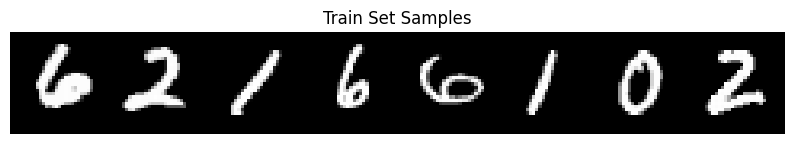

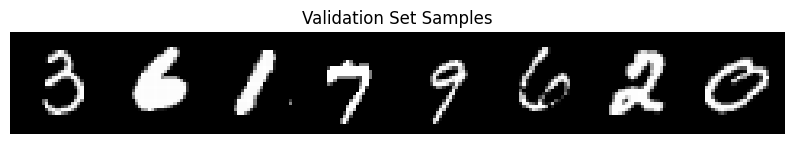

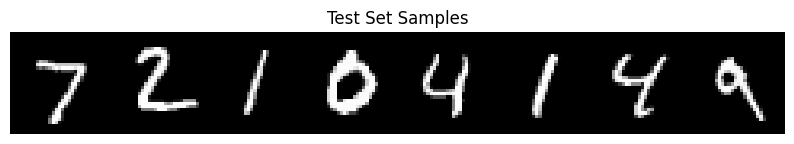

In [26]:
def show_batch(loader, title="Sample Images from DataLoader"):
    images, labels = next(iter(loader))  
    img_grid = torchvision.utils.make_grid(images[:8], nrow=8, padding=2, normalize=True)

    plt.figure(figsize=(10, 2))
    plt.imshow(img_grid.permute(1, 2, 0))  
    plt.title(title)
    plt.axis("off")
    plt.show()

show_batch(train_loader, title="Train Set Samples")
show_batch(val_loader, title="Validation Set Samples")
show_batch(test_loader, title="Test Set Samples")

In [27]:
## MLP Architecture (2 hidden, 1 input , 1 output layer), with ReLU, loss function CrossEntropyLoss, lr=0.001 and 10 rpochs

In [28]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),                  
            nn.Linear(784, 256), #hidden layer 1
            nn.ReLU(),
            nn.Linear(256, 128), #hidden layer 2
            nn.ReLU(),
            nn.Linear(128, 10) #output layer 10 neurons since we have classes           
        )

    def forward(self, x):
        return self.model(x)

model = MLP()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total

    # Validation loop
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {running_loss/len(train_loader):.4f} | Train Acc: {train_acc:.2f}% "
          f"| Val Loss: {val_loss/len(val_loader):.4f} | Val Acc: {val_acc:.2f}%")

#save model
os.makedirs("SavedModels", exist_ok=True)
torch.save(model.state_dict(), "SavedModels/mlp_mnist_state_dict.pth")
torch.save(model, "SavedModels/mlp_mnist_full_model.pth")
print("Model saved successfully!")

Epoch [1/10] Train Loss: 0.3684 | Train Acc: 88.79% | Val Loss: 0.1972 | Val Acc: 94.04%
Epoch [2/10] Train Loss: 0.1722 | Train Acc: 94.74% | Val Loss: 0.1527 | Val Acc: 95.23%
Epoch [3/10] Train Loss: 0.1243 | Train Acc: 96.08% | Val Loss: 0.1202 | Val Acc: 95.96%
Epoch [4/10] Train Loss: 0.0992 | Train Acc: 96.83% | Val Loss: 0.1300 | Val Acc: 95.83%
Epoch [5/10] Train Loss: 0.0853 | Train Acc: 97.24% | Val Loss: 0.1176 | Val Acc: 96.32%
Epoch [6/10] Train Loss: 0.0716 | Train Acc: 97.68% | Val Loss: 0.1339 | Val Acc: 95.82%
Epoch [7/10] Train Loss: 0.0639 | Train Acc: 97.96% | Val Loss: 0.1012 | Val Acc: 96.93%
Epoch [8/10] Train Loss: 0.0572 | Train Acc: 98.18% | Val Loss: 0.0978 | Val Acc: 97.17%
Epoch [9/10] Train Loss: 0.0518 | Train Acc: 98.28% | Val Loss: 0.0917 | Val Acc: 97.37%
Epoch [10/10] Train Loss: 0.0434 | Train Acc: 98.54% | Val Loss: 0.1052 | Val Acc: 96.81%
Model saved successfully!


In [29]:
## test accuracy (prove) on MNIST DATA
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Final Test Accuracy on MNIST: {100 * correct / total:.2f}%")

Final Test Accuracy on MNIST: 96.88%


# Test Trained MLP on Handwritten Dataset 

In [30]:
# Load your handwritten test data
images_tensor = torch.load("SavedData/images_tensor.pt")
labels_tensor = torch.load("SavedData/labels_tensor.pt")

# Make sure to move tensors to same device as model
images_tensor = images_tensor.to(device)
labels_tensor = labels_tensor.to(device)


In [31]:
model.eval()
correct = 0
total = labels_tensor.size(0)

with torch.no_grad():
    outputs = model(images_tensor)
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels_tensor).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on Handwritten Digits: {accuracy:.2f}%")

Accuracy on Handwritten Digits: 32.42%


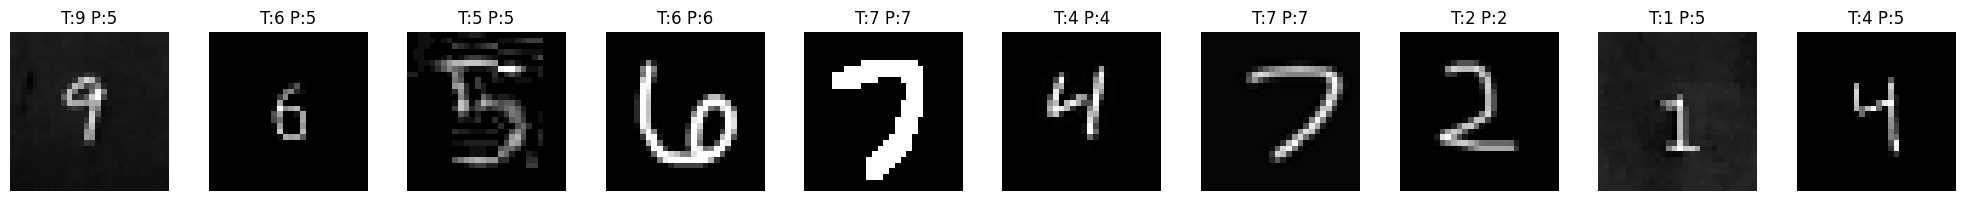

In [32]:
## plot the resulting handwritten data on the saved mode;l
import matplotlib.pyplot as plt

def show_predictions(images, labels, preds, n=10):
    plt.figure(figsize=(n*2, 2))
    for i in range(n):
        img = images[i].cpu().squeeze().numpy()
        true = labels[i].item()
        pred = preds[i].item()
        plt.subplot(1, n, i+1)
        plt.imshow(img, cmap="gray")
        plt.title(f"T:{true} P:{pred}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Show predictions
show_predictions(images_tensor, labels_tensor, predicted, n=10)

### Augmenting Handwritten Dataset

In [33]:
images_tensor = torch.load("SavedData/images_tensor.pt")
labels_tensor = torch.load("SavedData/labels_tensor.pt")

Reference links: 
- https://pytorch.org/vision/main/generated/torchvision.transforms.RandomAffine.html

In [40]:
handwritten_transform = transforms.RandomAffine(
    degrees=15,             #  rotation
    translate=(0.1, 0.1),   #  shift
    scale=(0.9, 1.1)        # zoom in/out
)

class AugmentedHandwrittenDataset(Dataset):
    def __init__(self, images_tensor, labels_tensor, transform=None):
        self.images = images_tensor  
        self.labels = labels_tensor
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

augmented_dataset = AugmentedHandwrittenDataset(
    images_tensor, labels_tensor, transform=handwritten_transform)
augmented_loader = DataLoader(augmented_dataset, batch_size=64, shuffle=False)

In [41]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in augmented_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on AUGMENTED Handwritten Digits: {accuracy:.2f}%")

Accuracy on AUGMENTED Handwritten Digits: 23.33%


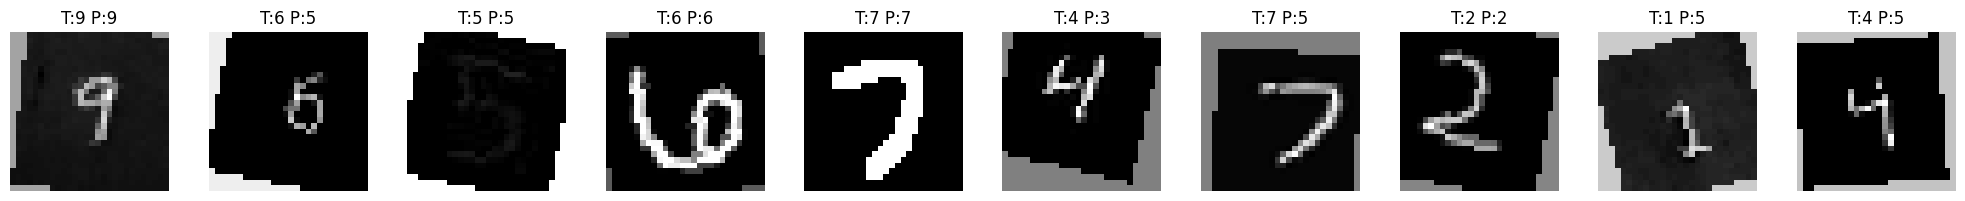

In [42]:
images, labels = next(iter(augmented_loader))
outputs = model(images.to(device))
_, preds = outputs.max(1)

show_predictions(images, labels, preds.cpu(), n=10)

### Augmenting MNIST Dataset to train again

In [44]:
augmented_mnist_transform = transforms.Compose([
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

augmented_mnist_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=augmented_mnist_transform)
train_dataset, val_dataset = random_split(augmented_mnist_dataset, [50000, 10000])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [46]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.model(x)

model = MLP()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [47]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    print(f"Epoch {epoch+1}/{num_epochs}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

#save model
os.makedirs("SavedModels", exist_ok=True)
torch.save(model.state_dict(), "SavedModels/mlp_mnist_augmented_state_dict.pth")
torch.save(model, "SavedModels/mlp_mnist_augmented_full_model.pth")
print("Model saved successfully!")

Epoch 1/10, Train Acc: 73.09%, Val Acc: 84.65%
Epoch 2/10, Train Acc: 88.93%, Val Acc: 87.83%
Epoch 3/10, Train Acc: 90.88%, Val Acc: 92.00%
Epoch 4/10, Train Acc: 92.22%, Val Acc: 90.48%
Epoch 5/10, Train Acc: 93.04%, Val Acc: 94.07%
Epoch 6/10, Train Acc: 93.50%, Val Acc: 93.94%
Epoch 7/10, Train Acc: 93.88%, Val Acc: 92.77%
Epoch 8/10, Train Acc: 94.26%, Val Acc: 92.89%
Epoch 9/10, Train Acc: 94.39%, Val Acc: 94.59%
Epoch 10/10, Train Acc: 94.68%, Val Acc: 94.44%
Model saved successfully!


In [61]:
import os
os.listdir("SavedModels")

['mlp_mnist_augmented_state_dict.pth',
 'mlp_mnist_full_model.pth',
 'mlp_mnist_augmented_full_model.pth',
 'mlp_mnist_state_dict.pth']

In [ ]:
## eval on handwritten

In [50]:
images_tensor = torch.load("SavedData/images_tensor.pt")
labels_tensor = torch.load("SavedData/labels_tensor.pt")

test_loader = DataLoader(TensorDataset(images_tensor, labels_tensor), batch_size=64, shuffle=False)

# Evaluate
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on Handwritten Digits (after training on Augmented MNIST): {accuracy:.2f}%")

Accuracy on Handwritten Digits (after training on Augmented MNIST): 49.70%


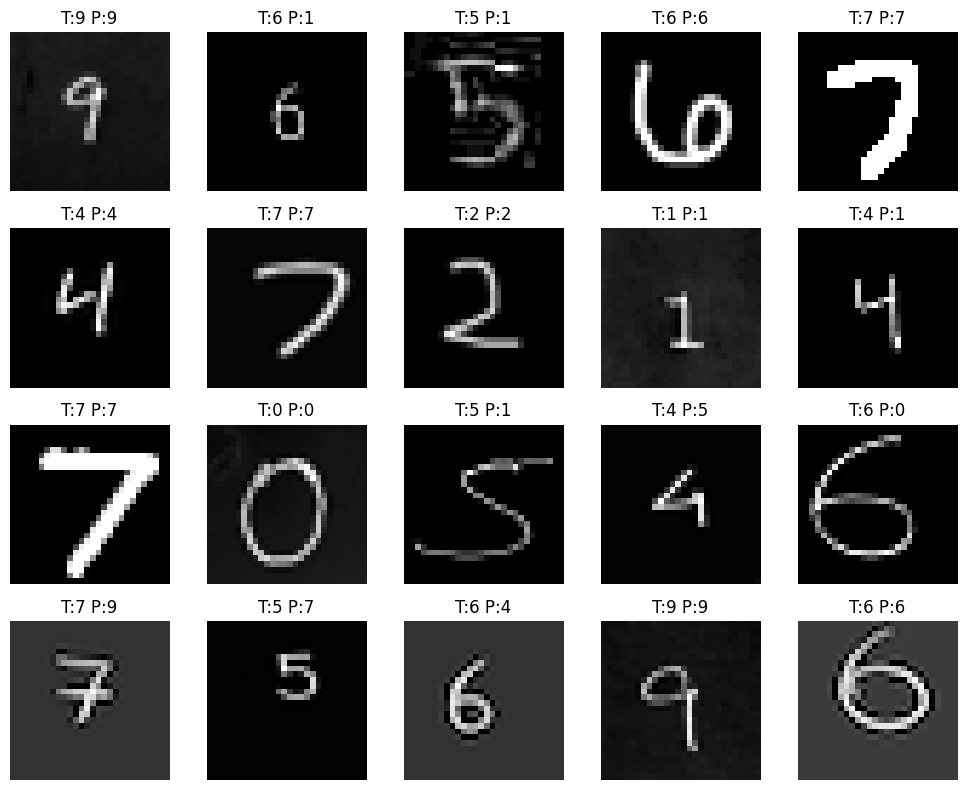

In [59]:
def show_predictions(images, labels, preds, n=20, per_row=5):
    rows = math.ceil(n / per_row)
    plt.figure(figsize=(per_row * 2, rows * 2))

    for i in range(n):
        img = images[i].cpu().squeeze().numpy()
        true = labels[i].item()
        pred = preds[i].item()

        plt.subplot(rows, per_row, i + 1)
        plt.imshow(img, cmap="gray")
        plt.title(f"T:{true} P:{pred}")
        plt.axis("off")

    plt.tight_layout()
    plt.show() 

images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

outputs = model(images)
_, preds = outputs.max(1)

show_predictions(images, labels, preds, n=20, per_row=5)

In [ ]:
####   -----------------------------------------PRADANYA'S WORK------------------------------------------------------- ##

# 2. Data Preparation
## 2.1 Define Image Transformations
We apply two transformations:

- ToTensor() to convert PIL images to Tensors in the [0, 1] range.
- Normalize((0.5,), (0.5,)) to shift the range to [-1, 1] for better neural network performance.

In [59]:
transform = transforms.Compose([
    # converts image to Tensor (0-1 range)
    transforms.ToTensor(),  
    # normalize to [-1,1]
    transforms.Normalize((0.5,), (0.5,))  
])

In [64]:
trainset = torchvision.datasets.MNIST(root='./data', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

## 2.3 Define Class Labels

We create a tuple `classes` containing string labels from 0 to 9, 
to map numeric labels to human-readable digits for visualization.

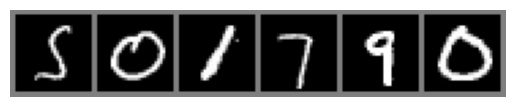

5 0 1 7 9 0


In [65]:
# Define classes (digit names)
classes = tuple(str(i) for i in range(10))

# Function to show our images
def imshow(img):
    img = img / 2 + 0.5  
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()


dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:6]))

print(' '.join(f'{classes[labels[j]]}' for j in range(6)))


In [66]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # First hidden layer
        self.fc1 = nn.Linear(28*28, 256)  
        # Second hidden layer
        self.fc2 = nn.Linear(256, 128)    
        # Output layer 
        self.fc3 = nn.Linear(128, 10)     

    def forward(self, x):
        x = x.view(-1, 28*28)  
        x = torch.relu(self.fc1(x))  
        x = torch.relu(self.fc2(x))  
        x = self.fc3(x)              
        return x

In [ ]:
# Define loss function and optimizer
model = MLP()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10  

for epoch in range(epochs):
    running_loss = 0.0
    model.train()

    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}] Loss: {running_loss/len(trainloader):.4f}")


Epoch [1/10] Loss: 0.3345
Epoch [2/10] Loss: 0.1555
Epoch [3/10] Loss: 0.1123
Epoch [4/10] Loss: 0.0922
Epoch [5/10] Loss: 0.0724
Epoch [6/10] Loss: 0.0678
Epoch [7/10] Loss: 0.0603
Epoch [8/10] Loss: 0.0523
Epoch [9/10] Loss: 0.0483
Epoch [10/10] Loss: 0.0434


In [68]:
# Evaluation
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on MNIST test images: {100 * correct / total:.2f}%')


Accuracy on MNIST test images: 97.58%


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move tensors to the device
images_tensor = images_tensor.to(device)
labels_tensor = labels_tensor.to(device)

images_tensor = images_tensor.to(device)
labels_tensor = labels_tensor.to(device)

model.eval()

# Disable gradient calculation for efficiency
with torch.no_grad():
    outputs = model(images_tensor)              
    _, predicted = torch.max(outputs, 1)        
    correct = (predicted == labels_tensor).sum().item()
    total = labels_tensor.size(0)
    accuracy = 100 * correct / total

print("Predictions:", predicted.cpu().numpy())
print("Ground Truth:", labels_tensor.cpu().numpy())
print(f"Accuracy on Group Digits: {accuracy:.2f}%")


Predictions: [0 0 0 0 3 5 5 0 0 2 0 0 5 5 5 5 7 4 7 9 5 7 7 7 5 7 1 7 5 5 9 0 0 1 6 1 1
 1 5 5 9 1 2 2 2 5 5 7 5 1 7 2 4 5 7 7 7 5 5 1 5 5 5 5 0 1 8 2 2 2 2 5 2 5
 2 7 2 0 5 5 5 5 4 2 5 2 5 7 5 5 5 5 5 5 5 2 5 2 2 3 5 3 3 3 5 9 9 3 9 3 2
 5 5 5 7 2 2 5 9 5 7 7 7 5 5 5 5 5 2 5 2 3 7 4 4 4 4 5 4 8 4 4 4 4 5 7 5 7
 5 7 5 9 5 7 7 7 5 5 7 4 5 5 5 4 4 5 5 6 5 5 5 5 5 5 5 5 5 5 5 7 5 9 2 0 5
 5 7 7 7 5 5 7 5 5 5 9 5 5 5 6 6 6 8 5 2 7 5 5 6 8 5 5 5 5 5 5 7 5 7 7 5 7
 6 5 5 6 6 2 2 5 2 7 2 7 2 1 7 5 5 7 7 7 7 7 7 7 7 9 2 2 9 5 7 7 7 7 5 7 7
 7 5 9 7 7 2 8 8 8 8 5 5 5 3 8 8 8 9 5 9 7 9 2 5 3 5 7 5 5 2 5 5 2 2 9 5 8
 8 9 9 9 2 2 5 1 8 9 9 9 5 7 5 9 7 3 9 7 1 7 7 7 7 5 5 1 7 5 9 9 9 7]
Ground Truth: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 

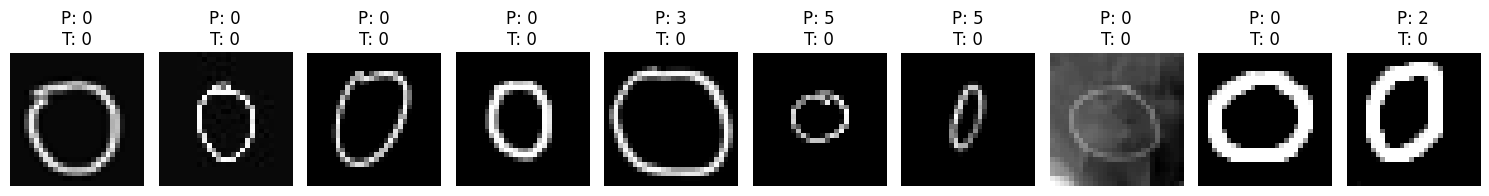

In [ ]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    outputs = model(images_tensor)
    _, predicted = torch.max(outputs, 1)

images_cpu = images_tensor.cpu()
predicted_cpu = predicted.cpu()
labels_cpu = labels_tensor.cpu()

N = min(10, len(images_cpu))  
plt.figure(figsize=(15, 3))

for i in range(N):
    plt.subplot(1, N, i + 1)
    plt.imshow(images_cpu[i].squeeze(), cmap='gray')
    plt.title(f"P: {predicted_cpu[i].item()}\nT: {labels_cpu[i].item()}")
    plt.axis('off')

plt.tight_layout()
plt.show()


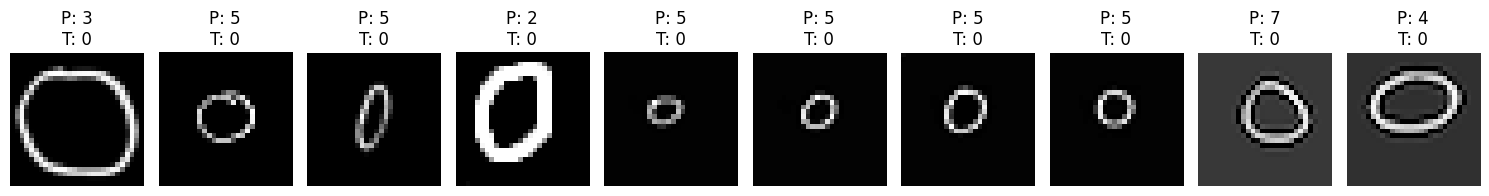

In [71]:
# Find indices of misclassified images
misclassified_indices = (predicted_cpu != labels_cpu).nonzero().flatten()

# Show up to 10 misclassified images
N = min(10, len(misclassified_indices))
plt.figure(figsize=(15, 3))

for i in range(N):
    idx = misclassified_indices[i]
    plt.subplot(1, N, i + 1)
    plt.imshow(images_cpu[idx].squeeze(), cmap='gray')
    plt.title(f"P: {predicted_cpu[idx].item()}\nT: {labels_cpu[idx].item()}")
    plt.axis('off')

plt.tight_layout()
plt.show()


## Hyperparameter Tuning

In [75]:
from torchvision import datasets
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)


In [76]:
def train_and_evaluate(hidden_sizes, lr, optimizer_name, num_epochs=10):
    # Define model architecture dynamically
    layers = [nn.Flatten()]
    input_size = 28 * 28
    for h in hidden_sizes:
        layers.append(nn.Linear(input_size, h))
        layers.append(nn.ReLU())
        input_size = h
    layers.append(nn.Linear(input_size, 10))
    model = nn.Sequential(*layers).to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        raise ValueError("Unsupported optimizer")

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluate on MNIST test
    model.eval()
    correct_mnist, total_mnist = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total_mnist += labels.size(0)
            correct_mnist += (predicted == labels).sum().item()
    mnist_acc = 100 * correct_mnist / total_mnist

    # Evaluate on team digits
    with torch.no_grad():
        outputs = model(images_tensor)
        _, predicted = torch.max(outputs, 1)
        correct_group = (predicted == labels_tensor).sum().item()
        group_acc = 100 * correct_group / labels_tensor.size(0)

    return mnist_acc, group_acc


In [77]:
configs = [
    {'hidden_sizes': [256, 128], 'lr': 0.01, 'opt': 'SGD'},
    {'hidden_sizes': [512, 256], 'lr': 0.001, 'opt': 'Adam'},
    {'hidden_sizes': [128],      'lr': 0.01, 'opt': 'SGD'},
    {'hidden_sizes': [256],      'lr': 0.001, 'opt': 'Adam'},
]

results = []

for i, config in enumerate(configs):
    print(f"Running config {i+1}: {config}")
    mnist_acc, group_acc = train_and_evaluate(config['hidden_sizes'], config['lr'], config['opt'])
    results.append((config, mnist_acc, group_acc))
    print(f"MNIST Acc: {mnist_acc:.2f}% | Group Acc: {group_acc:.2f}%\n")


Running config 1: {'hidden_sizes': [256, 128], 'lr': 0.01, 'opt': 'SGD'}
MNIST Acc: 97.53% | Group Acc: 34.55%

Running config 2: {'hidden_sizes': [512, 256], 'lr': 0.001, 'opt': 'Adam'}
MNIST Acc: 97.82% | Group Acc: 38.48%

Running config 3: {'hidden_sizes': [128], 'lr': 0.01, 'opt': 'SGD'}
MNIST Acc: 97.12% | Group Acc: 37.27%

Running config 4: {'hidden_sizes': [256], 'lr': 0.001, 'opt': 'Adam'}
MNIST Acc: 97.50% | Group Acc: 31.82%



In [78]:
print("Summary of Hyperparameter Tuning:\n")
for i, (cfg, mnist_acc, group_acc) in enumerate(results):
    print(f"Config {i+1}: {cfg}")
    print(f"  -> MNIST Accuracy: {mnist_acc:.2f}%")
    print(f"  -> Group Accuracy: {group_acc:.2f}%\n")


Summary of Hyperparameter Tuning:

Config 1: {'hidden_sizes': [256, 128], 'lr': 0.01, 'opt': 'SGD'}
  -> MNIST Accuracy: 97.53%
  -> Group Accuracy: 34.55%

Config 2: {'hidden_sizes': [512, 256], 'lr': 0.001, 'opt': 'Adam'}
  -> MNIST Accuracy: 97.82%
  -> Group Accuracy: 38.48%

Config 3: {'hidden_sizes': [128], 'lr': 0.01, 'opt': 'SGD'}
  -> MNIST Accuracy: 97.12%
  -> Group Accuracy: 37.27%

Config 4: {'hidden_sizes': [256], 'lr': 0.001, 'opt': 'Adam'}
  -> MNIST Accuracy: 97.50%
  -> Group Accuracy: 31.82%

